<a href="https://colab.research.google.com/github/Interaverse/Forecasting-monthly-copper-prices/blob/main/KNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

# Load the datasets by uploading the files to "files" section on Google Collab
train_data = pd.read_excel('training_data-11.xlsx') #Rename if needed
test_data = pd.read_excel('testing_data-11.xlsx') #Rename if needed

# Setting 'Copper_Price' as the target column that the model will use
train_scaled = train_data['Price_Copper'].values.reshape(-1,1)
test_scaled = test_data['Price_Copper'].values.reshape(-1,1)

In [ ]:
#This function is optional, but it improves performance
def create_dataset(dataset, time_step=10):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # Extracting time_step consecutive elements
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Corresponding future value as label
    return np.array(dataX), np.array(dataY)

# Initilize time step
time_step = 10
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)



In [ ]:
pip install numpy pandas scikit-learn openpyxl


# Baseline Model

In [ ]:
# Build the KNN model and set parameters
knn_model = KNeighborsRegressor(n_neighbors=5,leaf_size=30, metric='minkowski', p=2, weights='uniform')
# Fit (Train) the KNN model
knn_model.fit(X_train, y_train.ravel())


KNeighborsRegressor()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate predictions for both the training and testing datasets
train_predict = knn_model.predict(X_train)
test_predict = knn_model.predict(X_test)

# Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print('----------------')

# Calculate MSE performance metrics
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print('----------------')

# Calculate MAE performance metrics
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print('----------------')

# Calculate r2 performance metrics
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)
print(f'Train R2: {train_r2:.2f}')
print(f'Test R2: {test_r2:.2f}')


Train RMSE: 0.09
Test RMSE: 0.19
----------------
Train MSE: 0.01
Test MSE: 0.04
----------------
Train MAE: 0.05
Test MAE: 0.15
----------------
Train R2: 0.98
Test R2: 0.72


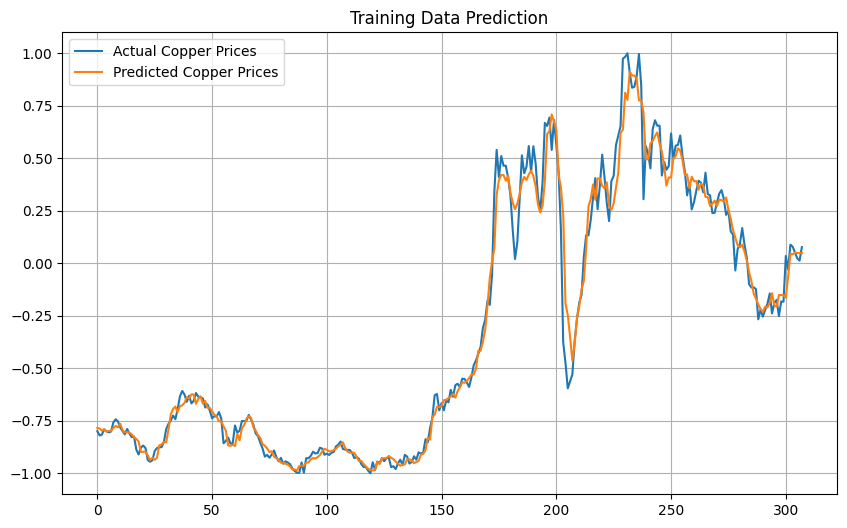

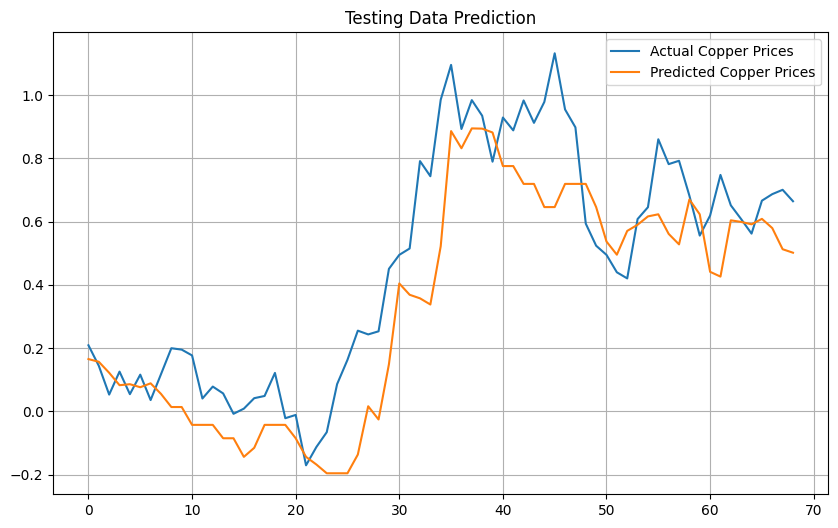

In [ ]:
# Plotting the actual vs predicted copper prices for training data
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual Copper Prices')
plt.plot(train_predict, label='Predicted Copper Prices')
plt.title('Training Data Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the actual vs predicted copper prices for testing data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Copper Prices')
plt.plot(test_predict, label='Predicted Copper Prices')
plt.title('Testing Data Prediction')
plt.legend()
plt.grid(True)
plt.show()


# DEAP Optimisation

In [ ]:
!pip install deap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

def evaluate_individual(individual):
    # Unpack individual's parameters
    n_neighbors, weights, metric = individual
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    model.fit(X_train, y_train.ravel())  # Ensure X_train and y_train are defined
    predictions = model.predict(X_test)  # Ensure X_test and y_test are defined
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)  # Calculate RMSE from MSE
    return (mse, rmse)

# Genetic operators
def mutate_individual(individual):
    if random.random() < 0.2:
        individual[0] = random.randint(1, 20)  # Vary number of neighbors
    return individual,

def crossover_individual(ind1, ind2):
    # Crossover for each parameter in the individual
    for i in range(len(ind1)):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Note: Minimize both MSE and RMSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_n_neighbors", random.randint, 1, 20)
toolbox.register("attr_weights", random.choice, ["uniform"]) # We only focus on Uniform weight, as Distance tends to favour training set more
toolbox.register("attr_metric", random.choice, ["euclidean", "manhattan","minkowski"])
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_neighbors, toolbox.attr_weights, toolbox.attr_metric),
                 n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", crossover_individual)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=30)

def print_best_of_generation(gen, pop):
    best_individual = min(pop, key=lambda ind: ind.fitness.values[0])
    print(f"Generation: {gen}")
    print(f"  Best Parameters: {best_individual}, MSE: {best_individual.fitness.values[0]}, RMSE: {best_individual.fitness.values[1]}")

# Custom loop for the genetic algorithm to print best individual per generation
ngen = 10
for gen in range(ngen):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    print_best_of_generation(gen, population)

best_individual = tools.selBest(population, k=1)[0]
print("Best individual found:")
print(f"  Parameters: {best_individual}")
print(f"  MSE: {best_individual.fitness.values[0]}, RMSE: {best_individual.fitness.values[1]}")

best_individual = tools.selBest(population, k=1)[0]
best_params = {
    'n_neighbors': best_individual[0],
    'weights': best_individual[1],
    'metric': best_individual[2]
}

Generation: 0
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 1
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 2
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 3
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 4
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 5
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 6
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 7
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, RMSE: 0.19123095471491808
Generation: 8
  Best Parameters: [4, 'uniform', 'euclidean'], MSE: 0.03656927804117905, 

# **Best Model: Based on DEAP Params**

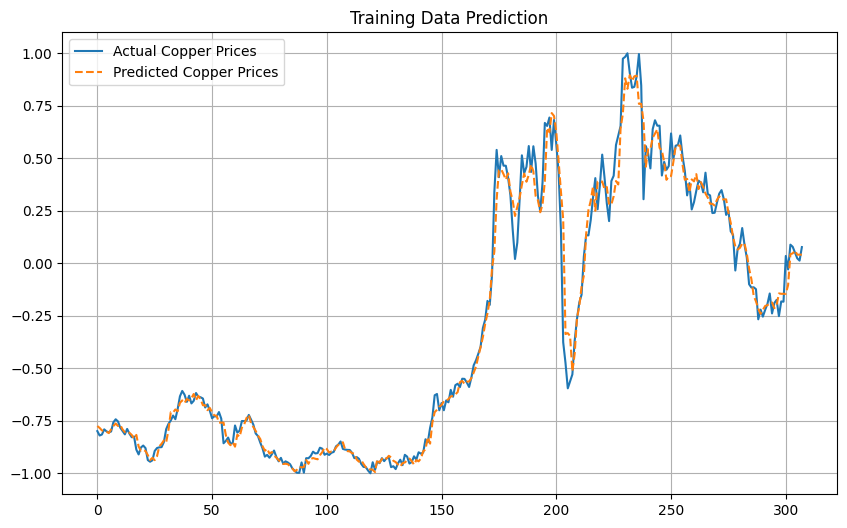

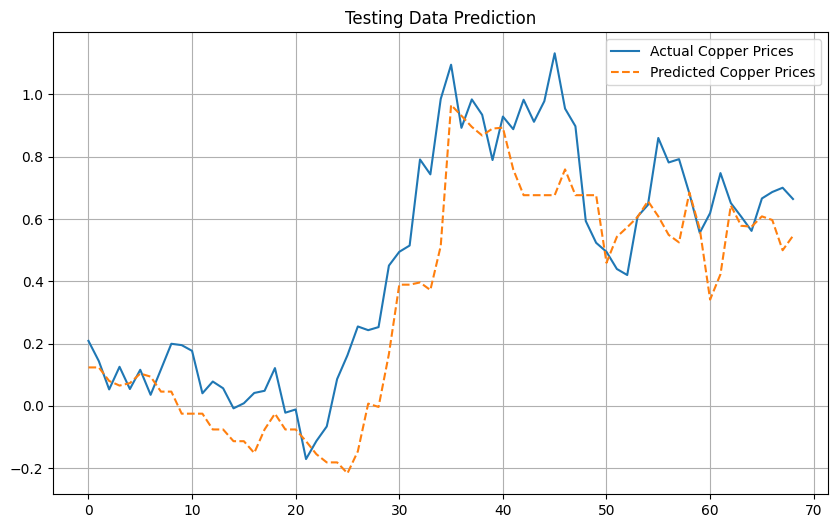

--------------------------
MSE: 0.03656927804117905
--------------------------
RMSE: 0.19123095471491808
--------------------------
MAE: 0.14968703293739533
--------------------------
R^2 Score: 0.7199632794465988
--------------------------


In [ ]:
# Initialize and fit the model with the best parameters identified by DEAP
model = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'],
                            weights=best_params['weights'],
                            metric=best_params['metric'])
model.fit(X_train, y_train.ravel())

# Predicting for both training and testing sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Evaluating performance on the testing set
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Plotting the actual vs predicted copper prices for training data
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual Copper Prices')
plt.plot(train_predictions, label='Predicted Copper Prices', linestyle='--')
plt.title('Training Data Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the actual vs predicted copper prices for testing data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Copper Prices')
plt.plot(test_predictions, label='Predicted Copper Prices', linestyle='--')
plt.title('Testing Data Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Output the scores
print('--------------------------')
print(f"MSE: {mse}")
print('--------------------------')
print(f"RMSE: {rmse}")
print('--------------------------')
print(f"MAE: {mae}")
print('--------------------------')
print(f"R^2 Score: {r2}")
print('--------------------------')


# **Cross-Validation: Based on DEAP Params**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Best DEAP parameters (simulate fetching these from DEAP's output)
deap_best_n_neighbors = best_individual[0]
deap_best_weights = best_individual[1]
deap_best_metric = best_individual[2]

# Prepare the time series cross-validator
tscv = TimeSeriesSplit(n_splits=10)

# Create a KNN model
model = KNeighborsRegressor()

# Define the parameter grid based on the  DEAP optimization results, the purpose is to validate DEAP best params
param_grid = {
    'n_neighbors': [deap_best_n_neighbors],
    'weights': [deap_best_weights],  # DEAP suggested weights
    'metric': [deap_best_metric],  # DEAP suggested metric
}

# Setup GridSearchCV to find the best parameters using the defined cross-validator
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

# Output the best parameters and the corresponding RMSE for the best model
best_params = grid_search.best_params_
best_cv_score = np.sqrt(-grid_search.best_score_)
print(f"Best parameters: {best_params}")
print(f"Best cross-validation RMSE: {best_cv_score}")

# Using the best estimator to make predictions on each fold and evaluate additional metrics
best_model = grid_search.best_estimator_

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Directly predict using the best model
    predictions = best_model.predict(X_test_fold)
    rmse = np.sqrt(mean_squared_error(y_test_fold, predictions))
    mae = mean_absolute_error(y_test_fold, predictions)
    r2 = r2_score(y_test_fold, predictions)
    print(f'Fold RMSE: {rmse}, Fold MAE: {mae}, Fold R2: {r2}')


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Best cross-validation RMSE: 0.3255279376126283
Fold RMSE: 0.03424515584710084, Fold MAE: 0.027443414688180786, Fold R2: 0.7753102354026966
Fold RMSE: 0.025594754682180983, Fold MAE: 0.017797142118672227, Fold R2: 0.8755688795769571
Fold RMSE: 0.019359383074149507, Fold MAE: 0.015595576560942289, Fold R2: 0.7835437068958687
Fold RMSE: 0.02131327742582169, Fold MAE: 0.016977901266477132, Fold R2: 0.13061600752641334
Fold RMSE: 0.03534301895737546, Fold MAE: 0.027754956984085966, Fold R2: 0.934168719503274
Fold RMSE: 0.12208994523124522, Fold MAE: 0.09028495735332129, Fold R2: 0.7942187819721529
Fold RMSE: 0.15405590413861517, Fold MAE: 0.10385666285123508, Fold R2: 0.8506744498956935
Fold RMSE: 0.13562536342632184, Fold MAE: 0.10084508732415166, Fold R2: 0.5666250155227034
Fold RMSE: 0.05681570164344301, Fold MAE: 0.04314745412251227, Fold R2: 0.83

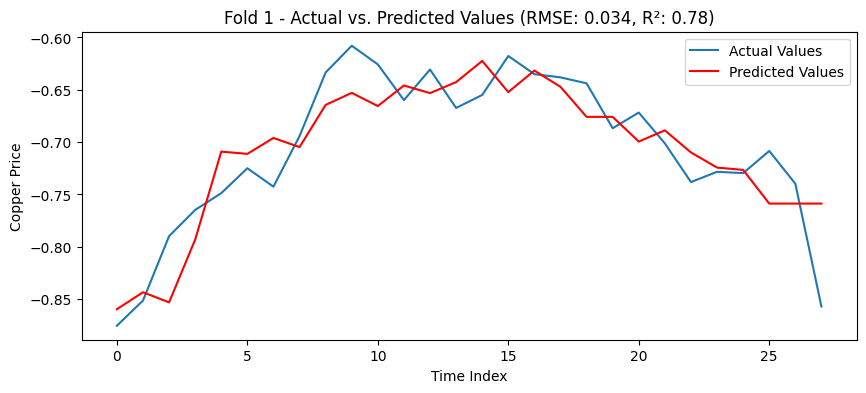

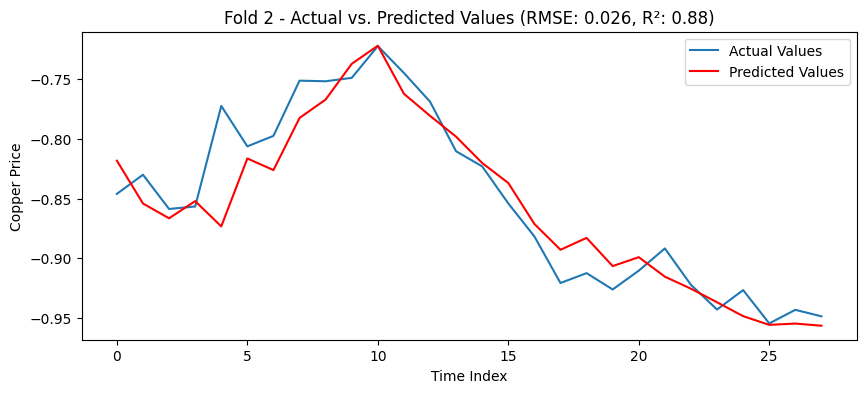

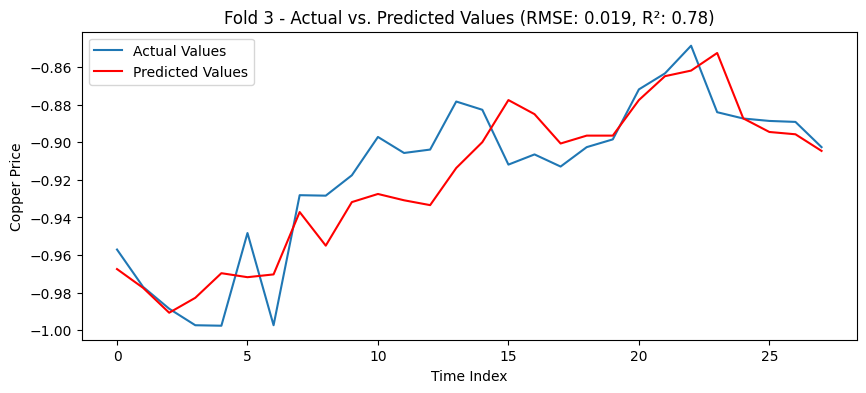

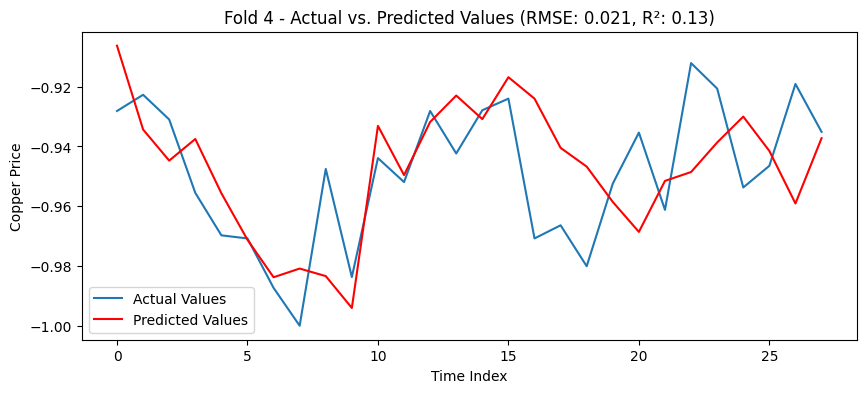

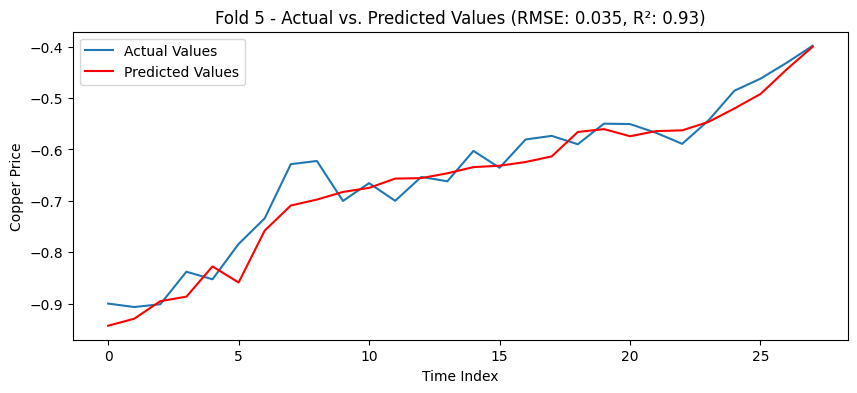

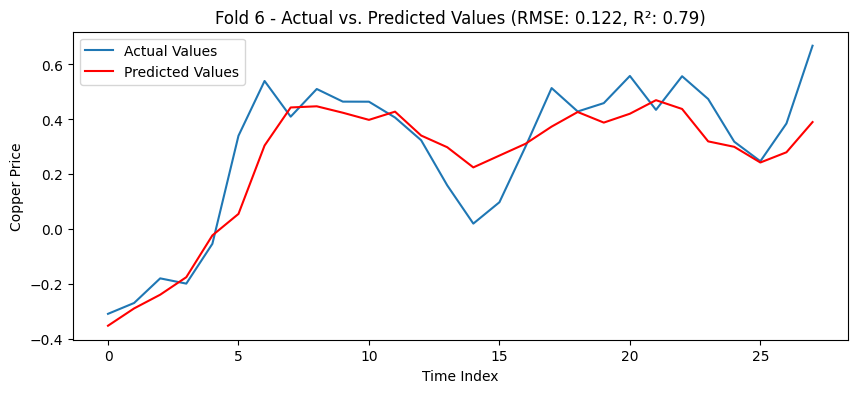

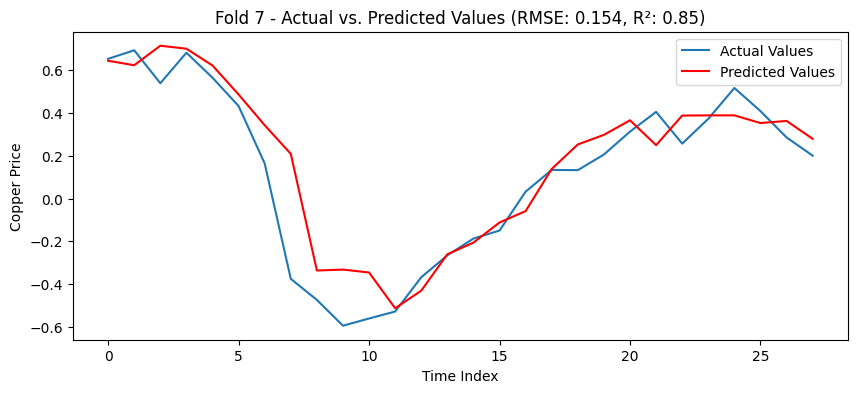

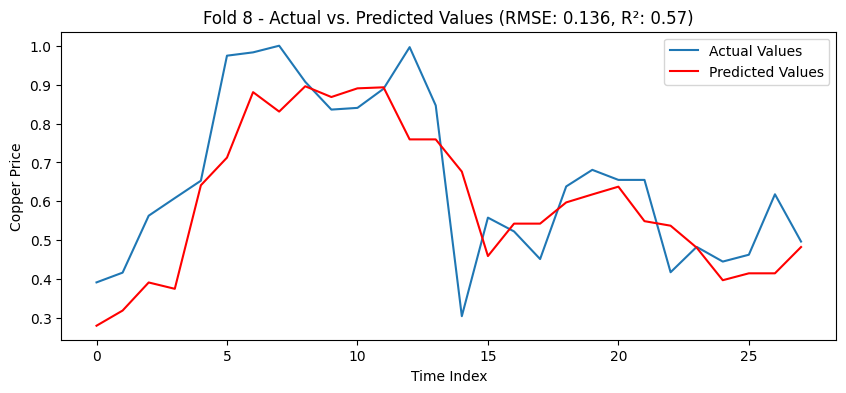

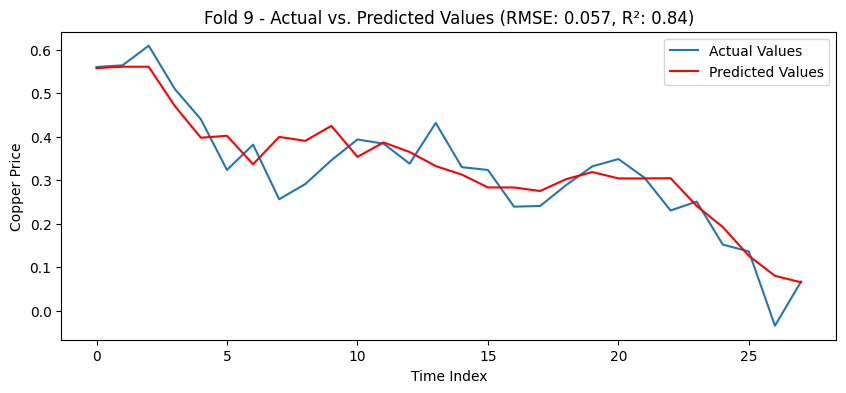

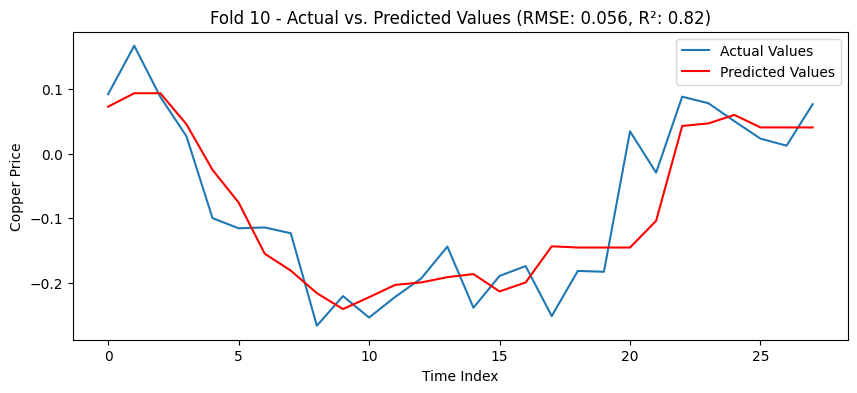

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

best_model = grid_search.best_estimator_

# Loop through each fold in the Time Series Split
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Predict using the best model
    fold_predictions = best_model.predict(X_test_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_test_fold, fold_predictions))
    fold_r2 = r2_score(y_test_fold, fold_predictions)  # Calculate R^2 score

    # Plotting the results for the current fold
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_fold, label='Actual Values')
    plt.plot(fold_predictions, 'r', label='Predicted Values')
    plt.title(f'Fold {i+1} - Actual vs. Predicted Values (RMSE: {fold_rmse:.3f}, R²: {fold_r2:.2f})')
    plt.xlabel('Time Index')
    plt.ylabel('Copper Price')
    plt.legend()
    plt.show()
